In [ ]:
!pip install highway-env gymnasium torch numpy tqdm
!sudo apt-get update
!sudo apt-get install build-essential swig
!pip install gymnasium[box2d]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 13.5 MB/s eta 0:00:00
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,192 kB]
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,531 kB]
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:11 http://security.ubuntu.c

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AlphaZeroNetwork(nn.Module):
    def __init__(self, input_shape, n_residual_layers=10, n_actions=5):
        super(AlphaZeroNetwork, self).__init__()
        self.input_shape = input_shape
        self.n_actions = n_actions

        # Convolution đầu tiên
        self.conv_layer = nn.Conv2d(input_shape[2], 256, kernel_size=3, padding=1)
        self.batch_norm = nn.BatchNorm2d(256)

        # Residual layers
        self.residual_layers = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(256, 256, kernel_size=3, padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(),
                nn.Conv2d(256, 256, kernel_size=3, padding=1),
                nn.BatchNorm2d(256)
            )
            for _ in range(n_residual_layers)
        ])

        # Value head
        self.value_conv = nn.Conv2d(256, 1, kernel_size=1)
        self.value_bn = nn.BatchNorm2d(1)
        self.fc_input_size = input_shape[0] * input_shape[1]

        self.value_fc1 = nn.Linear(self.fc_input_size, 256)
        self.value_dropout = nn.Dropout(0.1)  # Thêm Dropout
        self.value_fc2 = nn.Linear(256, 1)

        # Policy head
        self.policy_conv = nn.Conv2d(256, 2, kernel_size=1)
        self.policy_bn = nn.BatchNorm2d(2)
        self.policy_fc = nn.Linear(self.fc_input_size * 2, n_actions)
        self.policy_dropout = nn.Dropout(0.1)  # Thêm Dropout

    def forward(self, x):
        # Convolution đầu tiên và batch normalization
        x = F.relu(self.batch_norm(self.conv_layer(x)))

        # Residual layers
        for residual in self.residual_layers:
            residual_x = x
            x = residual(x) + residual_x
            x = F.relu(x)

        # Value head
        value = F.relu(self.value_bn(self.value_conv(x)))
        value = value.reshape(value.size(0), -1)
        value = F.relu(self.value_fc1(value))
        value = self.value_dropout(value)  # Áp dụng Dropout
        value = torch.tanh(self.value_fc2(value))

        # Policy head
        policy = F.relu(self.policy_bn(self.policy_conv(x)))
        policy = policy.reshape(policy.size(0), -1)
        policy = self.policy_fc(self.policy_dropout(policy))  # Áp dụng Dropout
        policy = F.softmax(policy, dim=1)

        return policy, value


In [ ]:
import highway_env
import gymnasium as gym

In [ ]:
duration = 15

In [ ]:
import numpy as np

# Buffer để lưu lịch sử Occupancy Grid
history_length = 5  # Số lượng occupancy grid cần lưu
ego_position = (4, 2)
# Kích thước của occupancy grid từ môi trường
grid_size = (21, 5)  # Ví dụ: W x H từ highway-env

def init_stack_of_grid(grid_size, ego_position, history_length=5):
    """
    Khởi tạo một mảng numpy chứa các occupancy grid và thông tin về tốc độ.

    Args:
        grid_size (tuple): Kích thước của grid (W, H).
        ego_position (tuple): Tọa độ của ego vehicle trong grid (x, y).
        max_speed (float): Tốc độ tối đa của xe.
        min_speed (float): Tốc độ tối thiểu của xe.
        history_length (int): Số lượng grid cần lưu cho lịch sử.

    Returns:
        numpy.ndarray: Một mảng numpy chứa các grid và thông tin tốc độ (shape: (history_length + 3, W, H)).
    """
    W, H = grid_size

    # Khởi tạo history stack với ego_position
    init_grid = np.zeros((W, H), dtype=np.float32)
    init_grid[ego_position] = 1.0
    history_stack = np.stack([init_grid.copy() for _ in range(history_length)], axis=0)

    # Tạo grid cho thông tin làn đường và tốc độ (toàn số 0 ban đầu)
    lane_info_grid = np.zeros((W, H), dtype=np.float32)
    speed_max_grid = np.full((W, H), 0.0, dtype=np.float32)
    speed_min_grid = np.full((W, H), 0.0, dtype=np.float32)
    ego_absolute_speed = np.full((W, H), 0.0, dtype=np.float32)
    # Ghép thành stack đầy đủ
    stack = np.concatenate([history_stack,
                            lane_info_grid[np.newaxis, :, :],
                            speed_max_grid[np.newaxis, :, :],
                            speed_min_grid[np.newaxis, :, :],
                            ego_absolute_speed[np.newaxis, :, :]], axis=0)
    return stack

def get_stack_of_grid(env, stack, new_grid, history_length=5):
    """
    Cập nhật stack với occupancy grid mới, thông tin làn đường và tốc độ tương đối.

    Args:
        stack (numpy.ndarray): Stack chứa lịch sử grid và thông tin tốc độ.
        new_grid (list of numpy.ndarray):
            - new_grid[0]: Occupancy grid mới.
            - new_grid[1]: Thông tin làn đường.
        history_length (int): Số lượng grid lịch sử.

    Returns:
        numpy.ndarray: Stack đã được cập nhật.
    """
    # Cập nhật history stack
    stack[:history_length - 1] = stack[1:history_length]
    stack[history_length - 1] = new_grid[0]
    stack[history_length] = new_grid[1]
    ego_speed = env.unwrapped.road.vehicles[0].speed
    max_speed = env.unwrapped.road.vehicles[0].target_speeds[-1]
    min_speed = env.unwrapped.road.vehicles[0].target_speeds[0]
    relative_speed_max = (ego_speed-max_speed)/(max_speed-min_speed)
    relative_speed_min = (ego_speed-min_speed)/(max_speed-min_speed)
    # Cập nhật stack tốc độ
    speed_max_grid = np.full(stack.shape[1:], relative_speed_max, dtype=np.float32)
    speed_min_grid = np.full(stack.shape[1:], relative_speed_min, dtype=np.float32)
    ego_absolute_speed = np.full(stack.shape[1:], ego_speed, dtype=np.float32)
    # Cập nhật stack tốc độ
    stack[history_length + 1] = speed_max_grid
    stack[history_length + 2] = speed_min_grid
    stack[history_length + 3] = ego_absolute_speed

    return stack


def softmax_policy(policy, available_actions):
    """
    Áp dụng softmax cho các xác suất trong policy dựa trên available_actions.

    :param policy: Dictionary chứa 5 hành động [0, 1, 2, 3, 4] với các xác suất tương ứng.
    :param available_actions: Danh sách các hành động có thể thực hiện (subset của [0, 1, 2, 3, 4]).
    :return: Dictionary chứa xác suất mới cho từng hành động (softmax áp dụng với các hành động khả dụng).
    """
    # Lấy các giá trị xác suất tương ứng với available_actions
    available_probs = np.array([policy[action] for action in available_actions])

    # Áp dụng softmax chỉ trên available_probs
    softmax_probs = available_probs / np.sum(available_probs)

    # Cập nhật xác suất mới
    updated_policy = {action: 0.0 for action in policy}  # Khởi tạo tất cả xác suất bằng 0
    for action, prob in zip(available_actions, softmax_probs):
        updated_policy[action] = prob

    return updated_policy

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NameError: name 'torch' is not defined

In [ ]:
import numpy as np
import copy

class MCTSNode:
    def __init__(self, env, parent, parent_action, prior_prob, c_puct=2.5):
        self.env = copy.deepcopy(env)
        self.parent = parent #parent node
        self.parent_action = parent_action
        self.children = {} #parent.children[action] = child
        self._n = 0
        self._W = 0
        self._P = prior_prob #Xác suất thực hiện hành động parent_action tại parent_node
        self.c_puct = c_puct
        min_speed = self.env.unwrapped.road.vehicles[0].target_speeds[0]
        max_speed = self.env.unwrapped.road.vehicles[0].target_speeds[-1]
        self.speed_bonus = (self.env.unwrapped.road.vehicles[0].speed - min_speed)/(max_speed - min_speed)
        self.collision = 0
        self.brake_penalty = 0
        if self.parent_action==4:
            self.brake_penalty = 1
        if self.env.unwrapped.road.vehicles[0].crashed:
            self.collision = 1 + 2*self.speed_bonus
        if self.parent is None:
            self.stack_of_planes = init_stack_of_grid(grid_size, ego_position)
        else:
            self.stack_of_planes = get_stack_of_grid(self.env, self.parent.stack_of_planes, env.unwrapped.observation_type.observe())
    def pucb_score(self):
        """
        Tính PUCB của node
        """
        if self._n == 0:
            Q = 0
        else:
            Q = self._W / self._n

        return Q + self.c_puct * self._P * np.sqrt(self.parent._n) / (1 + self._n) + 0.5*self.speed_bonus - 0.4*self.collision - 0.2*self.brake_penalty
    def select(self):
        """
        Chọn node có UCB lớn nhất
        """
        if not self.children:  # Nếu không có node con
            return None  # Hoặc raise Exception("No children nodes to select from")
        return max(self.children.values(), key=lambda child: child.pucb_score())

    def expand(self, action_priors):
        """
        Mở rộng cây bằng cách tạo node con
        action_priors là một dictionary chứa các xác suất prior của các action
        """
        for action, prob in action_priors.items():
            if action not in self.children and prob>0:
                #print(f"expanded {action} with {prob}")
                copy_env = copy.deepcopy(self.env)
                copy_env.step(action)
                self.children[action] = MCTSNode(copy_env, self, action, prob)

    def is_leaf(self):
        """
        Kiểm tra node có phải là leaf không
        """
        return self.children == {}
    def backpropagate(self, result):
        """
        Cập nhật visit count n và tổng điểm W
        new Q = new W/ new n
        """
        self._n += 1
        self._W += result
    def backpropagate_recursive(self, result):
        """
        Cập nhật toàn bộ đường đi từ node hiện tại đến root
        """
        if self.parent:
            self.parent.backpropagate_recursive(result)
        self.backpropagate(result)

In [ ]:
import copy

class MCTS:
    def __init__(self, root, network, c_puct=3.5, n_simulations=10, min_average_speed=23, duration=12):
        self.c_puct = c_puct
        self.root = root
        self._network = network.to(device)
        self._n_simulations = n_simulations
        self.ego_init_position = root.env.unwrapped.road.vehicles[0].position[0]
        self.min_average_speed = min_average_speed
        self.duration = duration
    def traverse_to_leaf(self):
        node = self.root
        while not node.is_leaf():
            node = node.select()
        return node

    def rollout(self):
        leaf_node = self.traverse_to_leaf()
        truncated = leaf_node.env.unwrapped._is_truncated() # True nếu hoàn thành episode
        crashed = leaf_node.env.unwrapped.road.vehicles[0].crashed # True nếu ego-vehicle xảy ra va chạm
        leaf_state = leaf_node.stack_of_planes
        state_tensor = torch.tensor(leaf_state, dtype=torch.float32).unsqueeze(0).to(device)
        predicted_policy, predicted_value = self._network(state_tensor)
        predicted_policy = {action: prob for action, prob in enumerate(predicted_policy.squeeze().tolist())}
        #print(predicted_policy)
        available_actions = leaf_node.env.unwrapped.get_available_actions()
        #print(available_actions)
        updated_policy = softmax_policy(predicted_policy, available_actions)
        #print(updated_policy)
        predicted_value = predicted_value.item()
        if not truncated and not crashed:
            leaf_node.expand(updated_policy)
        elif truncated:
            ego_last_position = leaf_node.env.unwrapped.road.vehicles[0].position[0]
            ego_average_speed = (ego_last_position - self.ego_init_position)/(self.duration-1)
            confidence_score = ego_average_speed / self.min_average_speed
            if confidence_score >=1.0:
                predicted_value = 1.0
            else:
                predicted_value = 0.0
        elif crashed:
            predicted_value = -1.0
        leaf_node.backpropagate_recursive(predicted_value)

    def move_to_new_root(self, action):
        """
        Chuyển gốc của cây MCTS tới node con tương ứng với hành động được chọn.
        """
        if action in self.root.children:
            self.root = self.root.children[action]  # Di chuyển gốc tới node con
            self.root.parent = None  # Ngắt liên kết với node cha để giảm bộ nhớ
        else:
            # Nếu node con không tồn tại, khởi tạo lại cây tại node gốc mới
            raise ValueError("Hành động không có trong cây hiện tại.")

In [ ]:
import torch
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler

import torch

class AlphaZeroTrainer:
    def __init__(self, network, env, c_puct=2, n_simulations=10, learning_rate=0.001, batch_size=32, epochs=10):
        self.network = network  # AlphaZeroNetwork
        self.env = env
        self.c_puct = c_puct
        self.n_simulations = n_simulations
        self.optimizer = optim.Adam(self.network.parameters(), lr=learning_rate)
        self.batch_size = batch_size
        self.epochs = epochs
        self.training_data = []  # Lưu trữ dữ liệu huấn luyện dạng (state, policy, value)
        self.action_list = []

    def self_play(self, seed=21):
        """
        Tạo dữ liệu huấn luyện thông qua self-play với MCTS.
        """
        # Khởi tạo lại môi trường và trạng thái ban đầu
        self.env.reset(seed=seed)
        state = init_stack_of_grid(grid_size, ego_position)
        done = self.env.unwrapped._is_truncated() or self.env.unwrapped._is_terminated()

        # Tạo gốc của cây MCTS
        root_node = MCTSNode(self.env, parent=None, parent_action=None, prior_prob=1.0, c_puct=self.c_puct)
        mcts = MCTS(root=root_node, network=self.network, c_puct=self.c_puct, n_simulations=self.n_simulations, duration=duration)

        while not done:
            # Thực hiện MCTS rollout để tính xác suất hành động
            state = get_stack_of_grid(env, state, self.env.unwrapped.observation_type.observe())
            for _ in range(self.n_simulations):
                mcts.rollout()
            # Thu thập xác suất hành động và giá trị của trạng thái hiện tại
            action_probs = {action: 0.0 for action in range(5)}  # Khởi tạo xác suất của tất cả hành động là 0
            for action, child in root_node.children.items():
                action_probs[action] = child._n / (root_node._n - 1)
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            #print(state_tensor.shape)
            predicted_value = root_node._W / root_node._n if root_node._n > 0 else 0

            # Lưu trữ dữ liệu huấn luyện


            # Chọn hành động dựa trên xác suất từ MCTS
            action = max(action_probs, key=action_probs.get)
            self.action_list.append(action)
            self.env.step(action)
            print(f"action chosen: {action}")
            self.training_data.append((state_tensor, action_probs, predicted_value, action))
            #(env.unwrapped.road.vehicles[0].target_lane_index[2])

            # Di chuyển gốc của MCTS đến node con tương ứng với hành động được chọn
            if action in root_node.children:
                mcts.move_to_new_root(action)
                root_node = mcts.root  # Cập nhật root_node cho vòng lặp kế tiếp
            else:
                raise ValueError("Action không tồn tại trong cây MCTS.")

            # Cập nhật trạng thái và kiểm tra điều kiện kết thúc
            done = self.env.unwrapped._is_truncated() or self.env.unwrapped._is_terminated()
        print("end self-play")

    def train(self):
        self.network.to(device)
        states, policies, values, actions = zip(*self.training_data)
        states = torch.cat(states).to(device)
        policies = torch.tensor([list(policy.values()) for policy in policies], dtype=torch.float32).to(device)
        values = torch.tensor(values, dtype=torch.float32).unsqueeze(1).to(device)
        actions = torch.tensor(actions, dtype=torch.long).to(device)

        # Weighted sampling
        class_counts = torch.bincount(actions)
        class_weights = 1.0 / (class_counts.float() + 1e-6)
        sample_weights = class_weights[actions]

        sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)
        dataset = TensorDataset(states, policies, values, actions)
        dataloader = DataLoader(dataset, batch_size=self.batch_size, sampler=sampler)

        # Khởi tạo các danh sách lưu trữ loss
        self.policy_losses = []
        self.value_losses = []
        self.total_losses = []

        for epoch in range(self.epochs):
            epoch_policy_loss = 0
            epoch_value_loss = 0
            epoch_total_loss = 0
            batch_count = 0

            for state_batch, policy_batch, value_batch, action_batch in dataloader:
                # Move batches to device
                state_batch = state_batch.to(device)
                policy_batch = policy_batch.to(device)
                value_batch = value_batch.to(device)

                # Forward pass
                predicted_policy, predicted_value = self.network(state_batch)

                # Losses
                policy_loss = F.kl_div(
                    F.log_softmax(predicted_policy, dim=-1),
                    policy_batch,
                    reduction='batchmean'
                )
                value_loss = F.mse_loss(predicted_value, value_batch)
                loss = 0.7*policy_loss + 0.3*value_loss

                # Backward pass
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                # Cộng dồn loss
                epoch_policy_loss += policy_loss.item()
                epoch_value_loss += value_loss.item()
                epoch_total_loss += loss.item()
                batch_count += 1

            # Tính loss trung bình cho mỗi epoch
            avg_policy_loss = epoch_policy_loss / batch_count
            avg_value_loss = epoch_value_loss / batch_count
            avg_total_loss = epoch_total_loss / batch_count

            # Lưu loss vào danh sách
            self.policy_losses.append(avg_policy_loss)
            self.value_losses.append(avg_value_loss)
            self.total_losses.append(avg_total_loss)

            print(f"Epoch {epoch + 1}/{self.epochs}, value loss: {avg_value_loss}, policy loss: {avg_policy_loss}, Loss: {avg_total_loss}")



    def save_model(self, path="alphazero_model.pth"):
        torch.save(self.network.state_dict(), path)

    def load_model(self, path="alphazero_model.pth"):
        self.network.load_state_dict(torch.load(path))


In [ ]:
import numpy as np
env_config = {
    "observation": {
        "type": "OccupancyGrid",
        "vehicles_count": 50,
        "features": ["presence", "on_road"],
        "features_range": {
            "x": [-100, 100],
            "y": [-100, 100],
            "vx": [-30, 30],
            "vy": [-20, 20]
        },
        "grid_size": [[-20, 85], [-12, 12]],
        "grid_step": [1, 1],
        "absolute": False
    },
    "collision_reward": 0,
    "left_lane_constraint": 0,
    "left_lane_reward": 0,
    "high_speed_reward": 0,
    "lanes_count": 4,
    "vehicles_density": 1.3+np.random.rand(),
    "action": {
        "type": "DiscreteMetaAction",
        "target_speeds": np.linspace(10, 30, 5)
    },
    "reward_speed_range": np.array([10, 30]),
    "duration": duration
}

env = gym.make("highway-fast-v0", config=env_config, render_mode='rgb_array')
env.reset()

(array([[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[1., 0., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.],
         ...,
         [1., 0., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.]]], dtype=float32),
 {'speed': 25,
  'crashed': False,
  'action': 4,
  'rewards': {'collision_reward': 0.0,
   'right_lane_reward': 1.0,
   'high_speed_reward': 0.75,
   'on_road_reward': 1.0}})

In [ ]:
env.unwrapped.observation_type.observe().shape

(2, 105, 24)

In [ ]:
import numpy as np
config = {
    "observation": {
        "type": "Kinematics",
        "vehicles_count": 8,
        "features": ["x", "y", "vx", "vy", "heading"],
        "absolute": True,
        "normalize": False,
        "order": "sorted",
    },
    "action": {
        "type": "DiscreteMetaAction",
        "target_speeds": np.linspace(10, 30, 5)
    },
    "lanes_count": 4,
    "vehicles_density": 1.3+np.random.rand(),
}
env = gym.make("highway-fast-v0", config=config, render_mode='rgb_array')
env.reset()

(array([[137.19153 ,   8.      ,  25.      ,   0.      ,   0.      ],
        [149.2662  ,   0.      ,  21.718655,   0.      ,   0.      ],
        [161.06892 ,  12.      ,  21.014984,   0.      ,   0.      ],
        [171.8239  ,  12.      ,  23.08253 ,   0.      ,   0.      ],
        [183.26306 ,   8.      ,  22.119751,   0.      ,   0.      ],
        [193.96764 ,   0.      ,  22.87285 ,   0.      ,   0.      ],
        [204.58548 ,   0.      ,  23.870564,   0.      ,   0.      ],
        [214.94185 ,   0.      ,  21.017954,   0.      ,   0.      ]],
       dtype=float32),
 {'speed': 25,
  'crashed': False,
  'action': 0,
  'rewards': {'collision_reward': 0.0,
   'right_lane_reward': 0.6666666666666666,
   'high_speed_reward': 0.5,
   'on_road_reward': 1.0}})

In [ ]:
env.unwrapped.observation_type.observe()

array([[137.19153 ,   8.      ,  25.      ,   0.      ,   0.      ],
       [149.2662  ,   0.      ,  21.718655,   0.      ,   0.      ],
       [161.06892 ,  12.      ,  21.014984,   0.      ,   0.      ],
       [171.8239  ,  12.      ,  23.08253 ,   0.      ,   0.      ],
       [183.26306 ,   8.      ,  22.119751,   0.      ,   0.      ],
       [193.96764 ,   0.      ,  22.87285 ,   0.      ,   0.      ],
       [204.58548 ,   0.      ,  23.870564,   0.      ,   0.      ],
       [214.94185 ,   0.      ,  21.017954,   0.      ,   0.      ]],
      dtype=float32)

In [ ]:
class KinematicToGridWrapper:
    def __init__(self):
        # Define grid parameters
        self.x_range = (-30, 90)  # meters relative to ego
        self.y_range = (-10, 10)   # meters relative to ego

        # Calculate grid size based on 1m per cell
        self.grid_size = (
            self.x_range[1] - self.x_range[0],  # 120 cells for x
            self.y_range[1] - self.y_range[0]   # 20 cells for y
        )

        # Car dimensions
        self.car_length = 5  # meters
        self.car_width = 2   # meters

    def get_car_footprint(self, x, y, heading):
        """Calculate which cells a car occupies given its center and heading"""
        occupied_cells = []

        cos_h = np.cos(heading)
        sin_h = np.sin(heading)

        corners_car = [
            (-self.car_length/2, -self.car_width/2),
            (self.car_length/2, -self.car_width/2),
            (self.car_length/2, self.car_width/2),
            (-self.car_length/2, self.car_width/2)
        ]

        corners_world = [
            (x + dx*cos_h - dy*sin_h, y + dx*sin_h + dy*cos_h)
            for dx, dy in corners_car
        ]

        min_x = min(x[0] for x in corners_world)
        max_x = max(x[0] for x in corners_world)
        min_y = min(x[1] for x in corners_world)
        max_y = max(x[1] for x in corners_world)

        for cell_x in range(int(min_x), int(max_x) + 1):
            for cell_y in range(int(min_y), int(max_y) + 1):
                if self.point_in_rotated_rect(
                    cell_x + 0.5, cell_y + 0.5,
                    x, y, heading,
                    self.car_length, self.car_width
                ):
                    occupied_cells.append((cell_x, cell_y))

        return occupied_cells

    def world_to_grid(self, x, y):
        """Convert world coordinates to grid coordinates"""
        grid_x = int(x - self.x_range[0])
        # Flip y-axis to maintain correct orientation
        grid_y = int(self.grid_size[1] - (y - self.y_range[0]) - 1)
        return grid_x, grid_y

    def point_in_rotated_rect(self, px, py, rect_x, rect_y, rect_angle, length, width):
        dx = px - rect_x
        dy = py - rect_y

        cos_h = np.cos(-rect_angle)
        sin_h = np.sin(-rect_angle)

        rotated_x = dx * cos_h - dy * sin_h
        rotated_y = dx * sin_h + dy * cos_h

        return (abs(rotated_x) <= length/2) and (abs(rotated_y) <= width/2)

    def process_observation(self, obs, left_bound, right_bound):
        """
        Process vehicle observations and return separate ego info and occupancy grid
        obs: list of [x, y, vx, vy, heading] for each vehicle (ego first)
        """
        # Extract ego vehicle state
        ego_x, ego_y, ego_vx, ego_vy, ego_heading = obs[0]

        # Initialize grid
        grid = np.zeros((self.grid_size[0], self.grid_size[1], 3), dtype=np.float32)

        to_left =  ego_y - left_bound
        to_right = right_bound - ego_y

        left = int(self.grid_size[1]/2 -1 - to_left)
        right = int(self.grid_size[1]/2 +1 + to_right)

        if left >= 0:
            grid[:, :left + 1, 0] = 2
            grid[:, :left + 1, 2] = ego_vy
        if right < self.grid_size[1]:
            grid[:, right:, 0] = 2
            grid[:, right:, 2] = ego_vy

        # Place ego vehicle
        ego_cells = self.get_car_footprint(0, 0, ego_heading)
        for cell_x, cell_y in ego_cells:
            grid_x, grid_y = self.world_to_grid(cell_x, cell_y)

            if (0 <= grid_x < self.grid_size[0] and
                0 <= grid_y < self.grid_size[1]):
                grid[grid_x, grid_y, 0] = 1
                grid[grid_x, grid_y, 1] = 0
                grid[grid_x, grid_y, 2] = 0

        # Process other vehicles
        for vehicle in obs[1:]:
            x, y, vx, vy, heading = vehicle

            # Get relative position
            rel_x = x - ego_x
            rel_y = y - ego_y

            # Get relative velocities
            rel_vx = vx - ego_vx
            rel_vy = vy - ego_vy

            # Get relative heading

            # Skip if vehicle center is out of range
            if (rel_x < self.x_range[0] or rel_x > self.x_range[1] or
                rel_y < self.y_range[0] or rel_y > self.y_range[1]):
                continue

            # Get all cells occupied by this vehicle
            occupied_cells = self.get_car_footprint(rel_x, rel_y, heading)

            # Convert to grid coordinates and update grid
            for cell_x, cell_y in occupied_cells:
                grid_x, grid_y = self.world_to_grid(cell_x, cell_y)

                if (0 <= grid_x < self.grid_size[0] and
                    0 <= grid_y < self.grid_size[1]):
                    grid[grid_x, grid_y, 0] = 2
                    grid[grid_x, grid_y, 1] = rel_vx
                    grid[grid_x, grid_y, 2] = rel_vy

        return np.array([grid])


In [ ]:
converter = KinematicToGridWrapper()

array([[[100, 100, 100],
        [100, 100, 100],
        [100, 100, 100],
        ...,
        [100, 100, 100],
        [100, 100, 100],
        [100, 100, 100]],

       [[100, 100, 100],
        [100, 100, 100],
        [100, 100, 100],
        ...,
        [100, 100, 100],
        [100, 100, 100],
        [100, 100, 100]],

       [[100, 100, 100],
        [100, 100, 100],
        [100, 100, 100],
        ...,
        [100, 100, 100],
        [100, 100, 100],
        [100, 100, 100]],

       ...,

       [[100, 100, 100],
        [100, 100, 100],
        [100, 100, 100],
        ...,
        [100, 100, 100],
        [100, 100, 100],
        [100, 100, 100]],

       [[100, 100, 100],
        [100, 100, 100],
        [100, 100, 100],
        ...,
        [100, 100, 100],
        [100, 100, 100],
        [100, 100, 100]],

       [[100, 100, 100],
        [100, 100, 100],
        [100, 100, 100],
        ...,
        [100, 100, 100],
        [100, 100, 100],
        [100, 100, 100]]], dtype=uint8)
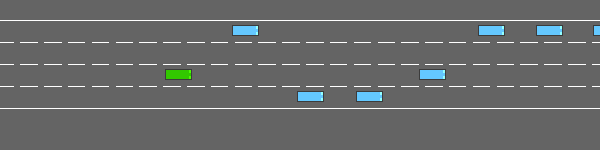

In [ ]:
env.render()

In [ ]:
occupancy = converter.process_observation(env.unwrapped.observation_type.observe(), -2, 4*(4-1)+2)

In [ ]:
occupancy.shape

(1, 120, 20, 3)

In [ ]:
reshaped_array = np.transpose(occupancy, (0, 3, 1, 2))

In [ ]:
reshaped_array

array([[[[0., 0., 0., ..., 2., 2., 2.],
         [0., 0., 0., ..., 2., 2., 2.],
         [0., 0., 0., ..., 2., 2., 2.],
         ...,
         [0., 0., 0., ..., 2., 2., 2.],
         [0., 0., 0., ..., 2., 2., 2.],
         [0., 0., 0., ..., 2., 2., 2.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]]], dtype=float32)

In [ ]:
for i in range(1):
    print(reshaped_array[i][0])

[[0. 0. 0. ... 2. 2. 2.]
 [0. 0. 0. ... 2. 2. 2.]
 [0. 0. 0. ... 2. 2. 2.]
 ...
 [0. 0. 0. ... 2. 2. 2.]
 [0. 0. 0. ... 2. 2. 2.]
 [0. 0. 0. ... 2. 2. 2.]]


In [ ]:
reshaped_array.shape

(1, 3, 120, 20)

In [ ]:
import pandas as pd

pd.DataFrame(env.unwrapped.observation_type.observe()[0])

,0,1,2,3,4
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,1.0,0.0
5,0.0,0.0,0.0,0.0,1.0
6,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,1.0
9,0.0,0.0,0.0,0.0,0.0


In [ ]:
network = AlphaZeroNetwork(input_shape=(21, 5, 9))

In [ ]:
trainer = AlphaZeroTrainer(network, env, c_puct=3.5, n_simulations=150, learning_rate=0.001, batch_size=64, epochs=25)

In [ ]:
def env_init(duration):
    env_config = {
        "observation": {
            "type": "OccupancyGrid",
            "vehicles_count": 50,
            "features": ["presence", "on_road"],
            "features_range": {
                "x": [-100, 100],
                "y": [-100, 100],
                "vx": [-30, 30],
                "vy": [-20, 20]
            },
            "grid_size": [[-20, 85], [-12.5, 12.5]],
            "grid_step": [5, 5],
            "absolute": False
        },
        "collision_reward": 0,
        "left_lane_constraint": 0,
        "left_lane_reward": 0,
        "high_speed_reward": 0,
        "lanes_count": 4,
        "vehicles_density": 1.6+2*np.random.rand(),
        "action": {
            "type": "DiscreteMetaAction",
            "target_speeds": np.linspace(15, 30, 4)
        },
        "reward_speed_range": np.array([15, 30]),
        "duration": duration
    }
    env = gym.make("highway-fast-v0", config=env_config, render_mode='rgb_array')
    return env

In [ ]:
trainer.training_data = training_data
len(trainer.training_data)

504

In [ ]:
training_data[:10]

[(tensor([[[[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
            [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
            [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
            [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
            [ 0.0000,  0.0000,  1.0000,  0.0000,  0.0000],
            [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
            [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
            [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
            [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
            [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
            [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
            [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
            [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
            [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
            [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
            [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
            [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000

In [ ]:
def training_pipeline(trainer, iterations=3, init_duration=15, duration_increase=5):
    trainer.network.train()
    for i in range(iterations):
        trainer.training_data = []
        env = env_init(duration=init_duration + duration_increase*i)
        trainer.env = env
        print(f"iter: {i}")
        j = np.random.randint(0, 20)
        while len(trainer.training_data)<500:
            print(f"self-play: {j}")
            trainer.self_play(seed=j)
            j = j+1
        trainer.train()

In [ ]:
training_pipeline(trainer, iterations=1, init_duration=12, duration_increase=0)

iter: 0
self-play: 15
action chosen: 4
action chosen: 0
action chosen: 0
action chosen: 0
action chosen: 4
action chosen: 2
action chosen: 2
action chosen: 0
action chosen: 0
action chosen: 2
action chosen: 3
action chosen: 2
end self-play
self-play: 16
action chosen: 0
action chosen: 2
action chosen: 0
action chosen: 2
action chosen: 2
action chosen: 0
action chosen: 0
action chosen: 2
action chosen: 1
action chosen: 0
action chosen: 3
action chosen: 0
end self-play
self-play: 17
action chosen: 0
action chosen: 3
action chosen: 2
action chosen: 2
action chosen: 0
action chosen: 2
action chosen: 1
action chosen: 1
action chosen: 0
action chosen: 0
action chosen: 0
action chosen: 1
end self-play
self-play: 18
action chosen: 0
action chosen: 4
action chosen: 0
action chosen: 3
action chosen: 2
action chosen: 0
action chosen: 0
action chosen: 1
action chosen: 4
action chosen: 1
action chosen: 3
action chosen: 3
end self-play
self-play: 19
action chosen: 0
action chosen: 2
end self-play
se

In [ ]:
trainer.train()

Epoch 1/25, value loss: 0.045133452862501144, policy loss: 0.9160004407167435, Loss: 0.6547403335571289
Epoch 2/25, value loss: 0.04640194773674011, policy loss: 0.8809627890586853, Loss: 0.6305945292115211
Epoch 3/25, value loss: 0.04732699482701719, policy loss: 0.8691692799329758, Loss: 0.6226165816187859
Epoch 4/25, value loss: 0.03641109261661768, policy loss: 0.8992185592651367, Loss: 0.6403763070702553
Epoch 5/25, value loss: 0.05027670902200043, policy loss: 0.8986830934882164, Loss: 0.6441611647605896
Epoch 6/25, value loss: 0.03680403879843652, policy loss: 0.8834169954061508, Loss: 0.6294331029057503
Epoch 7/25, value loss: 0.02548474562354386, policy loss: 0.8738240078091621, Loss: 0.6193222180008888
Epoch 8/25, value loss: 0.03348812251351774, policy loss: 0.8615213856101036, Loss: 0.6131113916635513
Epoch 9/25, value loss: 0.03200154332444072, policy loss: 0.8484939411282539, Loss: 0.6035462096333504
Epoch 10/25, value loss: 0.025850916630588472, policy loss: 0.8717398121

In [ ]:
trainer.train()

Epoch 1/25, value loss: 0.015597727673593909, policy loss: 0.8453591838479042, Loss: 0.5964307487010956
Epoch 2/25, value loss: 0.015550294308923185, policy loss: 0.8306827694177628, Loss: 0.5861430242657661
Epoch 3/25, value loss: 0.015293768374249339, policy loss: 0.8418229818344116, Loss: 0.5938642099499702
Epoch 4/25, value loss: 0.010339859232772142, policy loss: 0.8476448655128479, Loss: 0.5964533612132072
Epoch 5/25, value loss: 0.009246886766050011, policy loss: 0.8263258412480354, Loss: 0.5812021568417549
Epoch 6/25, value loss: 0.009734633611515164, policy loss: 0.8257836177945137, Loss: 0.5809689164161682
Epoch 7/25, value loss: 0.009812596370466053, policy loss: 0.823558934032917, Loss: 0.5794350206851959
Epoch 8/25, value loss: 0.008393678581342101, policy loss: 0.8088507577776909, Loss: 0.5687136277556419
Epoch 9/25, value loss: 0.0067023360170423985, policy loss: 0.8308693170547485, Loss: 0.5836192294955254
Epoch 10/25, value loss: 0.013334515620954335, policy loss: 0.83

In [ ]:
trainer.train()

Epoch 1/25, value loss: 0.009876716299913824, policy loss: 0.538826085627079, Loss: 0.3801412656903267
Epoch 2/25, value loss: 0.009268503985367715, policy loss: 0.5426043979823589, Loss: 0.38260361552238464
Epoch 3/25, value loss: 0.007645695295650512, policy loss: 0.5379843413829803, Loss: 0.3788827396929264
Epoch 4/25, value loss: 0.007619131123647094, policy loss: 0.50264972448349, Loss: 0.3541405387222767
Epoch 5/25, value loss: 0.00805033021606505, policy loss: 0.510963000357151, Loss: 0.3600891940295696
Epoch 6/25, value loss: 0.00605775770964101, policy loss: 0.5337317958474159, Loss: 0.37542957440018654
Epoch 7/25, value loss: 0.00443101447308436, policy loss: 0.5662569105625153, Loss: 0.397709134966135
Epoch 8/25, value loss: 0.0050315732369199395, policy loss: 0.5260448046028614, Loss: 0.369740828871727
Epoch 9/25, value loss: 0.005615682923234999, policy loss: 0.5283006764948368, Loss: 0.37149516865611076
Epoch 10/25, value loss: 0.006081850442569703, policy loss: 0.5277067

In [ ]:
trainer.train()

Epoch 1/25, value loss: 0.0031951416458468884, policy loss: 0.5311752110719681, Loss: 0.3727811872959137
Epoch 2/25, value loss: 0.004139360826229677, policy loss: 0.5236230343580246, Loss: 0.3677779249846935
Epoch 3/25, value loss: 0.004864028451265767, policy loss: 0.5463161394000053, Loss: 0.38388049975037575
Epoch 4/25, value loss: 0.005544296174775809, policy loss: 0.534779991954565, Loss: 0.3760092817246914
Epoch 5/25, value loss: 0.005334847286576405, policy loss: 0.5270686782896519, Loss: 0.3705485239624977
Epoch 6/25, value loss: 0.004582075373036787, policy loss: 0.5186851918697357, Loss: 0.3644542470574379
Epoch 7/25, value loss: 0.005072201776783913, policy loss: 0.5227697566151619, Loss: 0.3674604818224907
Epoch 8/25, value loss: 0.0034351873910054564, policy loss: 0.523801576346159, Loss: 0.36769165098667145
Epoch 9/25, value loss: 0.004019622690975666, policy loss: 0.5115478560328484, Loss: 0.35928938910365105
Epoch 10/25, value loss: 0.0024512042436981574, policy loss: 

In [ ]:
trainer.train()

Epoch 1/25, value loss: 0.002567623130744323, policy loss: 0.774659052491188, Loss: 0.31140419840812683
Epoch 2/25, value loss: 0.003119730157777667, policy loss: 0.7326611950993538, Loss: 0.29493632167577744
Epoch 3/25, value loss: 0.003041692601982504, policy loss: 0.7470468580722809, Loss: 0.30064376816153526
Epoch 4/25, value loss: 0.0025662221014499664, policy loss: 0.7361033409833908, Loss: 0.2959810718894005
Epoch 5/25, value loss: 0.0036534680984914303, policy loss: 0.7441808953881264, Loss: 0.2998644486069679
Epoch 6/25, value loss: 0.0037150935386307538, policy loss: 0.7602394297719002, Loss: 0.3063248246908188
Epoch 7/25, value loss: 0.003115095474640839, policy loss: 0.7379047200083733, Loss: 0.2970309518277645
Epoch 8/25, value loss: 0.004006323084468022, policy loss: 0.7357857152819633, Loss: 0.2967180944979191
Epoch 9/25, value loss: 0.0030063562153372914, policy loss: 0.738974966108799, Loss: 0.2973938100039959
Epoch 10/25, value loss: 0.0026652280357666314, policy loss

In [ ]:
trainer.train()

Epoch 1/25, value loss: 0.0020792494850376477, policy loss: 0.7821112183424143, Loss: 0.3140920469394097
Epoch 2/25, value loss: 0.0023048343495107614, policy loss: 0.7852046214617215, Loss: 0.31546476024847764
Epoch 3/25, value loss: 0.0020978959331002375, policy loss: 0.7853918763307425, Loss: 0.3154154901321118
Epoch 4/25, value loss: 0.0025804164335848047, policy loss: 0.7909184785989615, Loss: 0.3179156482219696
Epoch 5/25, value loss: 0.0029019165891580856, policy loss: 0.7691891009990985, Loss: 0.3094167961524083
Epoch 6/25, value loss: 0.0025177690057227244, policy loss: 0.7591259204424344, Loss: 0.3051610359778771
Epoch 7/25, value loss: 0.003385804002531446, policy loss: 0.7813655138015747, Loss: 0.3145776941226079
Epoch 8/25, value loss: 0.0022814846821487523, policy loss: 0.7678188268954937, Loss: 0.30849642707751346
Epoch 9/25, value loss: 0.0024339865373734096, policy loss: 0.770024836063385, Loss: 0.3094703325858483
Epoch 10/25, value loss: 0.0027886518510058522, policy 

In [ ]:
trainer.train()

Epoch 1/25, value loss: 0.0016059930421761237, policy loss: 0.748087540268898, Loss: 0.30019861832261086
Epoch 2/25, value loss: 0.0018115106504410505, policy loss: 0.7328485026955605, Loss: 0.2942263148725033
Epoch 3/25, value loss: 0.0015338028606493026, policy loss: 0.7433009520173073, Loss: 0.29824066907167435
Epoch 4/25, value loss: 0.001958362525328994, policy loss: 0.729535274207592, Loss: 0.2929891310632229
Epoch 5/25, value loss: 0.0018815879957401194, policy loss: 0.7476836442947388, Loss: 0.3002024106681347
Epoch 6/25, value loss: 0.0015357910451712087, policy loss: 0.7457286715507507, Loss: 0.2992129549384117
Epoch 7/25, value loss: 0.001540698911412619, policy loss: 0.7644374668598175, Loss: 0.3066994175314903
Epoch 8/25, value loss: 0.0017312274139840156, policy loss: 0.7394256889820099, Loss: 0.29680901393294334
Epoch 9/25, value loss: 0.0015384588186861947, policy loss: 0.7374354004859924, Loss: 0.2958972491323948
Epoch 10/25, value loss: 0.0012597679378814064, policy l

In [ ]:
trainer.save_model()

In [ ]:
trainer.policy_losses

[0.40658365190029144,
 0.42977282404899597,
 0.41249559074640274,
 0.4066058360040188,
 0.41874904558062553,
 0.4098006412386894,
 0.41221874952316284,
 0.39931339025497437,
 0.41175900399684906,
 0.42566440999507904,
 0.40154164284467697,
 0.39768144488334656,
 0.4226340614259243,
 0.412671472877264,
 0.4026656411588192,
 0.4093680903315544,
 0.411304347217083,
 0.41408737748861313,
 0.40173128619790077,
 0.4040847308933735,
 0.4132269285619259,
 0.40992435067892075,
 0.40480349212884903,
 0.40484076738357544,
 0.4050403982400894]

In [ ]:
trainer.value_losses

[0.01790817128494382,
 0.014984399895183742,
 0.014744499290827662,
 0.014888853067532182,
 0.010238806542474777,
 0.012695164186879992,
 0.009494942263700068,
 0.010412313626147807,
 0.013053481234237552,
 0.012554765213280916,
 0.01056453853379935,
 0.00921617919811979,
 0.009901861601974815,
 0.011869983398355544,
 0.010937420767731965,
 0.009106250945478678,
 0.007174103462602943,
 0.006775777088478208,
 0.00693329080240801,
 0.0058446069015190005,
 0.005615054164081812,
 0.004682713217334822,
 0.004031674034195021,
 0.005448682175483555,
 0.005847466847626492]

In [ ]:
trainer.total_losses

[0.424491822719574,
 0.44475722685456276,
 0.4272400885820389,
 0.4214946925640106,
 0.42898785322904587,
 0.4224958084523678,
 0.4217136912047863,
 0.40972570702433586,
 0.4248124845325947,
 0.43821917474269867,
 0.4121061824262142,
 0.4068976268172264,
 0.43253592029213905,
 0.4245414547622204,
 0.4136030562222004,
 0.41847433894872665,
 0.41847845166921616,
 0.42086315155029297,
 0.4086645841598511,
 0.4099293351173401,
 0.41884198784828186,
 0.41460705921053886,
 0.40883516892790794,
 0.4102894477546215,
 0.41088786348700523]

In [ ]:
trainer.network.eval()

AlphaZeroNetwork(
  (conv_layer): Conv2d(9, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (residual_layers): ModuleList(
    (0-9): 10 x Sequential(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (value_conv): Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
  (value_bn): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (value_fc1): Linear(in_features=105, out_features=256, bias=True)
  (value_dropout): Dropout(p=0.1, inplace=False)
  (value_fc2): Linear(in_features=256, out_features=1, bias=True)
  (policy_conv): Conv2d(256, 2

In [ ]:
env_config = {
    "observation": {
        "type": "OccupancyGrid",
        "vehicles_count": 50,
        "features": ["presence", "on_road"],
        "features_range": {
            "x": [-100, 100],
            "y": [-100, 100],
            "vx": [-30, 30],
            "vy": [-20, 20]
        },
        "grid_size": [[-20, 85], [-12.5, 12.5]],
        "grid_step": [5, 5],
        "absolute": False
    },
    "collision_reward": 0,
    "left_lane_constraint": 0,
    "left_lane_reward": 0,
    "high_speed_reward": 0,
    "lanes_count": 4,
    "vehicles_density": 1.4+2*np.random.rand(),
    "action": {
        "type": "DiscreteMetaAction",
        "target_speeds": np.linspace(15, 30, 4)
    },
    "reward_speed_range": np.array([15, 30]),
    "duration": duration
}
env = gym.make("highway-v0", config=env_config, render_mode='rgb_array')

In [ ]:
env.reset(seed=70)
action_list = []
state = init_stack_of_grid(grid_size, ego_position)

while not env.unwrapped._is_terminated() and not env.unwrapped._is_truncated():
    obs = env.unwrapped.observation_type.observe()
    state = get_stack_of_grid(env, state, obs)
    state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
    predicted_policy, predicted_value = trainer.network(state_tensor)
    available_actions = env.unwrapped.get_available_actions()
    print(available_actions)
    predicted_policy = {action: prob for action, prob in enumerate(predicted_policy.squeeze().tolist())}
    updated_policy = softmax_policy(predicted_policy, available_actions)
    print(updated_policy)
    print(predicted_value)
    action = max(updated_policy, key=updated_policy.get)
    action_list.append(action)
    print(f"action chosen: {action}")
    env.step(action)

[1, 0, 2, 3, 4]
{0: 0.0004930129016808558, 1: 0.539013514966998, 2: 0.4193606156309552, 3: 0.00014089751027295322, 4: 0.04099195899009302}
tensor([[-0.3550]], device='cuda:0', grad_fn=<TanhBackward0>)
action chosen: 1
[1, 0, 2, 3, 4]
{0: 1.6186651014599495e-05, 1: 0.9954221214854275, 2: 0.0032667605654648456, 3: 1.1246712982483226e-05, 4: 0.0012836845851104941}
tensor([[-0.2271]], device='cuda:0', grad_fn=<TanhBackward0>)
action chosen: 1
[1, 0, 2, 3, 4]
{0: 0.0003096297342546839, 1: 0.9986277499481067, 2: 7.445840800137055e-05, 3: 2.3755059523992087e-06, 4: 0.0009857864036848967}
tensor([[-0.5767]], device='cuda:0', grad_fn=<TanhBackward0>)
action chosen: 1
[1, 0, 2, 3, 4]
{0: 0.00014615986344276727, 1: 0.00045102187193078, 2: 0.9993774628766277, 3: 1.7121871341265604e-05, 4: 8.233516657560087e-06}
tensor([[-0.0505]], device='cuda:0', grad_fn=<TanhBackward0>)
action chosen: 2
[1, 0, 3, 4]
{0: 0.0040817371715860225, 1: 0.9872418695461778, 2: 0.0, 3: 0.007429916291171405, 4: 0.001246476

In [ ]:
trainer.save_model()

# REPLAY BUFFER

In [ ]:
import numpy as np
import random

class AlphaZeroTrainer:
    def __init__(self, network, env, c_puct=2, n_simulations=10, learning_rate=0.001, batch_size=32, epochs=10, alpha=0.6, beta=0.4):
        self.network = network
        self.env = env
        self.c_puct = c_puct
        self.n_simulations = n_simulations
        self.optimizer = optim.Adam(self.network.parameters(), lr=learning_rate)
        self.batch_size = batch_size
        self.epochs = epochs
        self.alpha = alpha  # Điều chỉnh độ ưu tiên (0: uniform sampling, 1: fully prioritized)
        self.beta = beta    # Điều chỉnh bias (tăng dần qua các epochs)
        self.replay_buffer = []  # Replay buffer với trọng số ưu tiên
        self.priorities = []     # Lưu trữ trọng số ưu tiên

    def self_play(self, seed=21):
        self.env.reset(seed=seed)
        state = init_stack_of_grid(grid_size, ego_position)
        done = self.env.unwrapped._is_truncated() or self.env.unwrapped._is_terminated()

        root_node = MCTSNode(self.env, parent=None, parent_action=None, prior_prob=1.0, c_puct=self.c_puct)
        mcts = MCTS(root=root_node, network=self.network, c_puct=self.c_puct, n_simulations=self.n_simulations, duration=duration)

        while not done:
            state = get_stack_of_grid(env, state, self.env.unwrapped.observation_type.observe())
            for _ in range(self.n_simulations):
                mcts.rollout()

            action_probs = {action: 0.0 for action in range(5)}
            for action, child in root_node.children.items():
                action_probs[action] = child._n / (root_node._n - 1)

            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            predicted_value = root_node._W / root_node._n if root_node._n > 0 else 0

            action = max(action_probs, key=action_probs.get)
            self.env.step(action)
            print(f"action chosen: {action}")

            # Tính TD-error và lưu vào replay buffer
            td_error = abs(predicted_value - self.network(state_tensor)[1].item())  # Giá trị tuyệt đối của TD-error
            priority = (td_error + 1e-6) ** self.alpha  # Thêm epsilon để tránh priority = 0

            self.replay_buffer.append((state_tensor, action_probs, predicted_value, action))
            self.priorities.append(priority)

            if action in root_node.children:
                mcts.move_to_new_root(action)
                root_node = mcts.root
            else:
                raise ValueError("Action không tồn tại trong cây MCTS.")

            done = self.env.unwrapped._is_truncated() or self.env.unwrapped._is_terminated()

    def sample_from_buffer(self):
        probabilities = np.array(self.priorities) / sum(self.priorities)
        indices = np.random.choice(len(self.replay_buffer), self.batch_size, p=probabilities)
        weights = (len(self.replay_buffer) * probabilities[indices]) ** (-self.beta)
        weights /= weights.max()  # Chuẩn hóa weights

        batch = [self.replay_buffer[i] for i in indices]
        states, policies, values, actions = zip(*batch)
        policies_tensor = torch.tensor([list(policy.values()) for policy in policies], dtype=torch.float32)
        return torch.cat(states), policies_tensor, torch.tensor(values, dtype=torch.float32).unsqueeze(1), torch.tensor(actions), torch.tensor(weights, dtype=torch.float32)

    def train(self):
        self.network.to(device)

        for epoch in range(self.epochs):
            states, policies, values, actions, weights = self.sample_from_buffer()
            states = states.to(device)
            policies = policies.to(device)
            values = values.to(device)
            weights = weights.to(device)

            predicted_policy, predicted_value = self.network(states)

            policy_loss = F.kl_div(F.log_softmax(predicted_policy, dim=-1), policies, reduction='none').mean(dim=-1)
            value_loss = F.mse_loss(predicted_value, values, reduction='none')

            # Tổng hợp loss có trọng số
            loss = (weights * (policy_loss + value_loss)).mean()

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            print(f"Epoch {epoch + 1}/{self.epochs}, Loss: {loss.item()}")

            # Cập nhật beta theo thời gian
            self.beta = min(1.0, self.beta + 0.001)
    def save_model(self, path="alphazero_model.pth"):
        torch.save(self.network.state_dict(), path)

    def load_model(self, path="alphazero_model.pth"):
        self.network.load_state_dict(torch.load(path))

In [ ]:
trainer = AlphaZeroTrainer(network, env, n_simulations=15, batch_size=32)

In [ ]:
trainer.self_play(seed=20)

action chosen: 0
action chosen: 3
action chosen: 2
action chosen: 1
action chosen: 4
action chosen: 3
action chosen: 4
action chosen: 4
action chosen: 1
action chosen: 0
action chosen: 1
action chosen: 0
action chosen: 1
action chosen: 3
action chosen: 4
action chosen: 1
action chosen: 1
action chosen: 3
action chosen: 1
action chosen: 4
action chosen: 1
action chosen: 1
action chosen: 1
action chosen: 1
action chosen: 1
action chosen: 2
action chosen: 1
action chosen: 1
action chosen: 0


In [ ]:
trainer.network.train()

AlphaZeroNetwork(
  (conv_layer): Conv2d(8, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (residual_layers): ModuleList(
    (0-9): 10 x Sequential(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (value_conv): Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
  (value_bn): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (value_fc1): Linear(in_features=105, out_features=256, bias=True)
  (value_dropout): Dropout(p=0.1, inplace=False)
  (value_fc2): Linear(in_features=256, out_features=1, bias=True)
  (policy_conv): Conv2d(256, 2

In [ ]:
trainer.train()

Epoch 1/25, value loss: 0.01790817128494382, policy loss: 0.40658365190029144, Loss: 0.424491822719574
Epoch 2/25, value loss: 0.014984399895183742, policy loss: 0.42977282404899597, Loss: 0.44475722685456276
Epoch 3/25, value loss: 0.014744499290827662, policy loss: 0.41249559074640274, Loss: 0.4272400885820389
Epoch 4/25, value loss: 0.014888853067532182, policy loss: 0.4066058360040188, Loss: 0.4214946925640106
Epoch 5/25, value loss: 0.010238806542474777, policy loss: 0.41874904558062553, Loss: 0.42898785322904587
Epoch 6/25, value loss: 0.012695164186879992, policy loss: 0.4098006412386894, Loss: 0.4224958084523678
Epoch 7/25, value loss: 0.009494942263700068, policy loss: 0.41221874952316284, Loss: 0.4217136912047863
Epoch 8/25, value loss: 0.010412313626147807, policy loss: 0.39931339025497437, Loss: 0.40972570702433586
Epoch 9/25, value loss: 0.013053481234237552, policy loss: 0.41175900399684906, Loss: 0.4248124845325947
Epoch 10/25, value loss: 0.012554765213280916, policy lo

In [ ]:
training_data[:10]

[(tensor([[[[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
            [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
            [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
            [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
            [ 0.0000,  0.0000,  1.0000,  0.0000,  0.0000],
            [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
            [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
            [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
            [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
            [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
            [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
            [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
            [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
            [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
            [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
            [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
            [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000

In [ ]:
import pickle

# Lưu danh sách vào tệp pickle
with open('training_data_9_layers.pkl', 'wb') as f:
    pickle.dump(training_data, f)

In [ ]:
import pickle

with open('training_data_9_layers.pkl', 'rb') as f:
    training_data = pickle.load(f)